In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.autograd import Variable

In [2]:
# simple discriminator that decides between real and fake images
class Discriminator(nn.Module):
    def __init__(self, in_features, num_classes: int = 10):
        super().__init__()
        
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        
        self.disc = nn.Sequential(
            nn.Linear(in_features+ num_classes, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        conditional = self.label_embedding(y)
        conditional_inputs = torch.cat([x, conditional], dim=-1)
        return self.disc(conditional_inputs)

In [3]:
# simple generator that generates fake images from random noise
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim, num_classes: int = 10):
        super().__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.gen = nn.Sequential(
            nn.Linear(z_dim + num_classes, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )
        
    def forward(self, x, y):
        conditional_inputs = torch.cat([x, self.label_embedding(y)], dim=-1)
        return self.gen(conditional_inputs)


In [4]:
# initialize hyperparams
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
image_dim = 28 * 28 * 1  # 784
batch_size = 32
num_epochs = 100

In [5]:
# intitialize discriminator, generator and some fixed noise which we can use to see the progress 
# of the generator
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [6]:
# load the dataset
dataset = datasets.MNIST(root="./", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# intilize two optimizers for each the generator and the discriminator
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
# initialize Summary Writers for Tensorboard
writer_fake = SummaryWriter(f"lightning_logs/fake_CGAN")
writer_real = SummaryWriter(f"lightning_logs/real_CGAN")
step = 0

In [7]:
# Training loop
for epoch in range(num_epochs):
    epoch_gloss = 0
    epoch_dloss = 0
    for batch_idx, (real, targets) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        targets = targets.to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        conditional = torch.randint(0, 10, (batch_size,)).to(device)
        fake = gen(noise, conditional)
        disc_real = disc(real, targets).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake, conditional).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        epoch_dloss += lossD
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake, conditional).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        epoch_gloss += lossG
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise, targets).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                step += 1
                
    print(
            f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {epoch_dloss/len(loader):.4f}, loss G: {epoch_gloss/len(loader):.4f}"
            )
    writer_real.add_scalar('d_loss', epoch_dloss/len(loader), epoch)
    writer_fake.add_scalar('g_loss', epoch_gloss/len(loader), epoch)

Epoch [0/100] Batch 0/1875                       Loss D: 0.6684, loss G: 0.7087
Epoch [0/100] Batch 1874/1875                       Loss D: 0.4381, loss G: 1.3397
Epoch [1/100] Batch 0/1875                       Loss D: 0.5715, loss G: 1.0322
Epoch [1/100] Batch 1874/1875                       Loss D: 0.5369, loss G: 1.2136
Epoch [2/100] Batch 0/1875                       Loss D: 0.3992, loss G: 1.5451
Epoch [2/100] Batch 1874/1875                       Loss D: 0.5866, loss G: 1.1605
Epoch [3/100] Batch 0/1875                       Loss D: 0.2482, loss G: 1.6673
Epoch [3/100] Batch 1874/1875                       Loss D: 0.6845, loss G: 1.0139
Epoch [4/100] Batch 0/1875                       Loss D: 0.3725, loss G: 1.6295
Epoch [4/100] Batch 1874/1875                       Loss D: 0.6226, loss G: 1.1047
Epoch [5/100] Batch 0/1875                       Loss D: 0.5510, loss G: 1.1345
Epoch [5/100] Batch 1874/1875                       Loss D: 0.6845, loss G: 1.0582
Epoch [6/100] Batch 0/

In [14]:
z = Variable(torch.randn(100, z_dim)).cuda()
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).cuda()

In [24]:
images = gen(z, labels).reshape(-1, 1, 28, 28)

In [28]:
grid = make_grid(images, nrow=10, normalize=True)
writer_fake.add_image(
                    "Mnist Fake Results", grid, global_step=0
                )

(-0.5, 301.5, 301.5, -0.5)

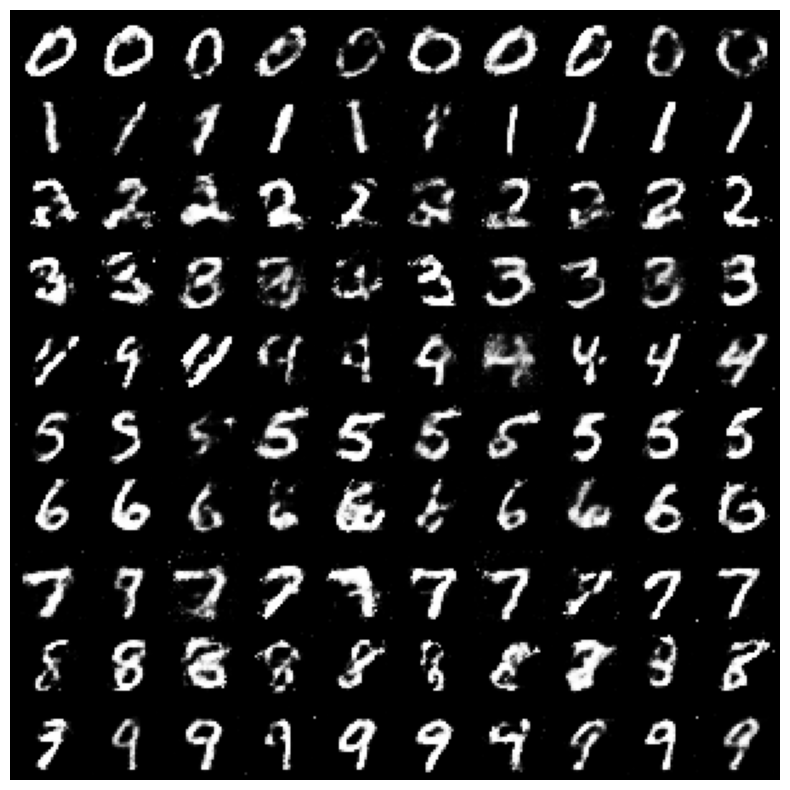

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid.permute(1, 2, 0).data.cpu(), cmap='binary')
ax.axis('off')